In [2]:
import torch
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor

https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
#Download MNIST dataset in local system

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [6]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [7]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [8]:
print(train_data.targets.size())

torch.Size([60000])


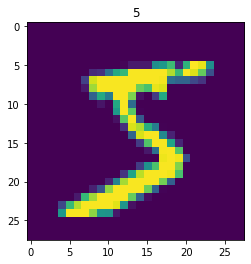

In [9]:
import matplotlib.pyplot as plt
#plt.imshow(train_data.data[0], cmap='gray')
plt.imshow(train_data.data[0])

plt.title('%i' % train_data.targets[0])
plt.show()

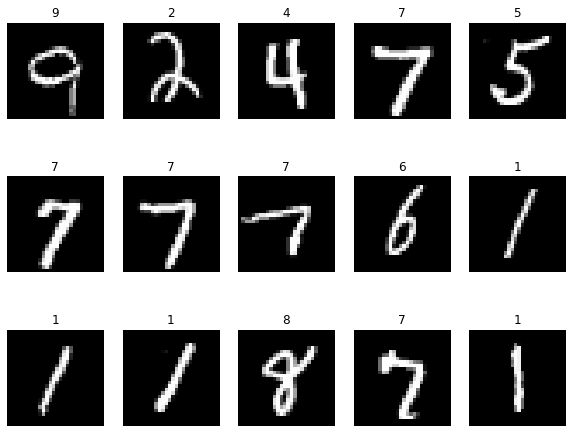

In [10]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#DataLoader is an iterable that abstracts complexity for us in an easy API.

In [11]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f39d29410d0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f39d29413d0>}

#Let us create CNN using torch.nn.Module.
We will use 2 fully convolutional layers, Relu activation function and MaxPooling.

***Conv2d: Applies a 2D convolution over an input signal composed of several input planes.***

Conv2d parameters

in_channels (int) — Number of channels in the input image

out_channels (int) — Number of channels produced by the convolution

kernel_size (int or tuple) — Size of the convolving kernel

stride (int or tuple, optional) — Stride of the convolution. Default: 1

padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0

In [12]:
#Using Sequential to create a small model. 
#When `model` is run, input will first be passed to `Conv2d(1,16,5)`.

import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), #Applies a 2D max pooling over an input signal          
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        self.out = nn.Linear(32 * 7 * 7, 10) # fully connected layer, output 10 classes
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)  
        print(x)     
        output = self.out(x)
        return output, x    # return x for visualization

In [13]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [14]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [15]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

#Train the model
Create a function called train() and pass num of epochs, model and data loaders as input parameters.

In [16]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train() #inherit from nn.Module
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   ## traing batch
            b_y = Variable(labels)   ## target batch (label)
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

Streaming output truncated to the last 5000 lines.
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0

In [17]:
def test():
    # Test the model
    cnn.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            print("test_output", test_output)
            pred_y = torch.max(test_output, 1)[1].data.squeeze() # 1 represents direction of dimentions, extract the max probability
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
test()

Streaming output truncated to the last 5000 lines.
         -3.0760e+01, -1.5752e+01,  2.6904e+00, -1.0406e+01, -4.4285e+00],
        [-1.3065e+01, -5.8244e+00, -6.3530e+00, -1.3791e+01, -6.0693e+00,
         -1.7335e+01, -2.3496e+01,  1.6426e+01, -8.0696e+00, -2.8670e+00],
        [-1.2575e+01, -2.7657e+00, -5.3811e+00, -1.4469e+01, -5.6220e+00,
         -2.5128e+01, -3.4855e+01,  1.4984e+01, -9.4617e+00,  2.2742e+00],
        [ 1.6806e+01, -2.9734e+01,  3.3239e+00, -1.3966e+01, -1.8732e+01,
         -1.3888e+01, -9.4161e+00, -6.8028e+00, -6.8667e+00, -2.0160e+00],
        [-7.6790e+00,  1.4113e+01, -1.5646e+00, -1.5803e+01, -5.5720e+00,
         -1.1715e+01, -2.7727e+00, -9.3416e+00, -1.0603e-01, -1.8062e+01],
        [-2.1773e+01, -3.0000e+01, -1.7868e+01, -1.2034e+01,  1.4554e+00,
         -1.6337e+01, -1.8375e+01, -6.2877e+00, -3.2160e-01,  1.6892e+01],
        [ 1.3891e+01, -2.0387e+01, -1.5585e+00, -3.6852e+00, -2.7525e+01,
         -8.1114e+00, -9.4475e+00, -2.1026e+01, -4.6544